In [11]:
import pandas as pd
import numpy as np

def loader():
    """Reading data from keys"""
    with open("data/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("data/data_{}.csv".format(str(key)))

    return dictex

In [2]:
df = loader()

In [3]:
# from horizon_handler
HORIZON_FEATURES = ['radiation', 'shade']

# from SMHI
FCST_FEATURES = ['AirTemp', 'DewPoint', 'RainPrecip', 'SnowPrecip', 'SnowPrecipAccumulated', 'WindSpeed',
                 'AirPressure', 'OctalCloudCoverage', 'PrecipAmount']
# from METRo
EBM_FEATURES = ['air_temp', 'dew_point', 'surf_temp', 'water_amount', 'snow_amount', 'sub_temp']


# setting the independent and dependent features
INDEPENDENT_FEATURES = HORIZON_FEATURES + FCST_FEATURES + EBM_FEATURES

In [4]:
# Random Forest parameters
RFR_PARAMS = {
    'n_estimators': 60,
    'max_features': 'sqrt',
    'min_samples_leaf': 10,
    'max_depth': 8}

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import sys
import pickle

def get_best_parameters(samples, targets):
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestRegressor()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(samples, targets)
    
    return rf_random.best_params_

def fit_forest(samples, targets, params=RFR_PARAMS):
    model = RandomForestRegressor(**params).fit(samples, targets)
    #p = pickle.dumps(model)
    #print(sys.getsizeof(p))
    return model

def forecast_forest(model, samples):
    predictions = model.predict(samples)
    return predictions

def getValues(data):
    data.set_index("Date Time", inplace=True)
    included = np.array(data[INDEPENDENT_FEATURES + ['surf_temp_sqerror']].notnull().all(axis=1))
    rsi = {
        "data": data.loc[included, INDEPENDENT_FEATURES].values.astype(np.float), 
        "target": data.loc[included, 'surf_temp_sqerror'].values.astype(np.float)
    }
    return train_test_split(rsi["data"], rsi["target"], test_size=0.3, random_state=0)


In [18]:
dfTest = loader()
rfr_params = dict()

def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in dfTest.keys():
    if allowed_key(key):
        X_train, X_test, y_train, y_test = getValues(dfTest[key])
        
        best_params = get_best_parameters(X_train, y_train)
        rfr_params[key] = best_params
        print(key, best_params)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.4min finished


(1419, 1) {'n_estimators': 136, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished
/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(1419, 5) {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


(1419, 9) {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


(1419, 18) {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished
/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(1433, 1) {'n_estimators': 52, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


(1433, 5) {'n_estimators': 73, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


(1433, 9) {'n_estimators': 157, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


(1433, 18) {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished
/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(1440, 1) {'n_estimators': 31, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.7min finished


(1440, 5) {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


(1440, 9) {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


(1440, 18) {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished
/Users/Jesper/miniconda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


(1417, 1) {'n_estimators': 178, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


(1417, 5) {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


(1417, 9) {'n_estimators': 52, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.1min finished


(1417, 18) {'n_estimators': 136, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}


In [6]:
rfr_params = dict()

rfr_params[(1419, 1)] = {'n_estimators': 136, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}
rfr_params[(1419, 5)] = {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
rfr_params[(1419, 9)] = {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
rfr_params[(1419, 18)] = {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
rfr_params[(1433, 1)] = {'n_estimators': 52, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}
rfr_params[(1433, 5)] = {'n_estimators': 73, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}
rfr_params[(1433, 9)] = {'n_estimators': 157, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}
rfr_params[(1433, 18)] = {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
rfr_params[(1440, 1)] = {'n_estimators': 31, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}
rfr_params[(1440, 5)] = {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
rfr_params[(1440, 9)] = {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
rfr_params[(1440, 18)] = {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
rfr_params[(1417, 1)] = {'n_estimators': 178, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 90, 'bootstrap': True}
rfr_params[(1417, 5)] = {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
rfr_params[(1417, 9)] = {'n_estimators': 52, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': False}
rfr_params[(1417, 18)] = {'n_estimators': 136, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}

In [7]:
from matplotlib import pyplot
import matplotlib.pyplot as plt

def plotPredictions(key, true, predictions):
    plt.figure(figsize=(16,7))
    plt.subplot(121)
    pyplot.scatter(true, predictions, color="red", alpha=0.5, s=5)
    pyplot.xlim(0,20)
    pyplot.ylim(0,20)
    pyplot.plot(range(60), color='black', alpha=0.2)
    pyplot.grid()
    pyplot.title(key, fontsize=16)
    pyplot.xlabel('surf_temp_sqerror')
    pyplot.ylabel('Estimated surf_temp_sqerror')

In [15]:
def experiment(repeats, data, key, params):
    X_train, X_test, y_train, y_test = getValues(data)
    MSE_benchmark = 100
    index_val = 20

    error_scores = list()
    results = pd.DataFrame()
    
    predictionsBest = list()
    trueBest = list()
    print(key)
    for r in range(repeats):
        forest_model = fit_forest(X_train, y_train, params)
        
        with open('models/rfr/model_{}_{}'.format(key, r), 'wb') as f:
            pickle.dump(forest_model, f)

        predictions = forecast_forest(forest_model, X_test)
        true = y_test
    
        # report performance
        mse = mean_squared_error(true, predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        if (mse < MSE_benchmark):
            MSE_benchmark = mse
            predictionsBest = predictions
            trueBest = true
            index_val = r
        # plotPredictions(key, true, predictions)
    #for name, value in zip(INDEPENDENT_FEATURES, forest_model.feature_importances_):
        #print(value*100)
    #print(index_val, )
    return trueBest, predictionsBest, error_scores

In [16]:
%matplotlib inline

df = loader()

import warnings
warnings.filterwarnings('ignore')

repeats = 10
features = 1
results = dict()
trueVals = []
predictedVals = []


def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores = experiment(repeats, df[key], key, rfr_params[key])
        results[key] = error_scores
        trueVals.extend(true)
        predictedVals.extend(predictions)
    

(1419, 1)
1) Test MSE: 0.442
2) Test MSE: 0.447
3) Test MSE: 0.449
4) Test MSE: 0.450
5) Test MSE: 0.443
6) Test MSE: 0.446
7) Test MSE: 0.441
8) Test MSE: 0.445
9) Test MSE: 0.448
10) Test MSE: 0.443
(1419, 5)
1) Test MSE: 9.604
2) Test MSE: 9.235
3) Test MSE: 10.084
4) Test MSE: 9.507
5) Test MSE: 9.212
6) Test MSE: 9.546
7) Test MSE: 9.945
8) Test MSE: 9.827
9) Test MSE: 9.627
10) Test MSE: 9.729
(1419, 9)
1) Test MSE: 7.903
2) Test MSE: 7.822
3) Test MSE: 8.392
4) Test MSE: 7.766
5) Test MSE: 8.883
6) Test MSE: 8.185
7) Test MSE: 8.109
8) Test MSE: 8.573
9) Test MSE: 7.722
10) Test MSE: 8.373
(1419, 18)
1) Test MSE: 8.477
2) Test MSE: 8.537
3) Test MSE: 9.207
4) Test MSE: 9.611
5) Test MSE: 8.122
6) Test MSE: 8.561
7) Test MSE: 8.302
8) Test MSE: 7.785
9) Test MSE: 8.106
10) Test MSE: 8.979
(1433, 1)
1) Test MSE: 0.263
2) Test MSE: 0.265
3) Test MSE: 0.269
4) Test MSE: 0.260
5) Test MSE: 0.265
6) Test MSE: 0.261
7) Test MSE: 0.263
8) Test MSE: 0.266
9) Test MSE: 0.261
10) Test MSE:

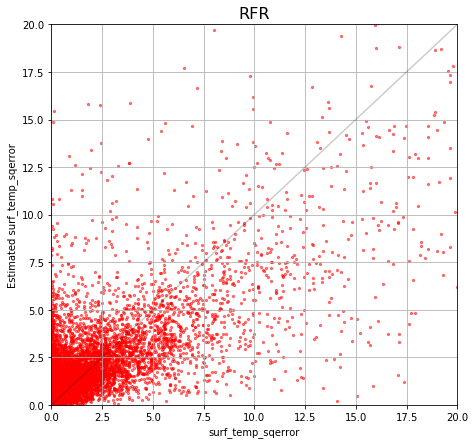

In [29]:
plotPredictions('RFR', trueVals, predictedVals)

Text(0, 0.5, 'Estimated surf_temp_sqerror')

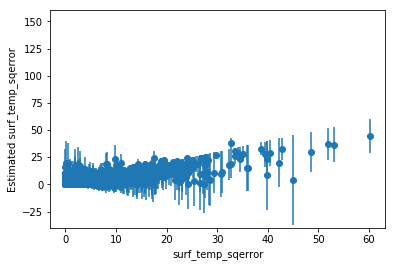

In [44]:
import math

diffValsSquared = (np.asarray(trueVals) - np.asarray(predictedVals)) ** 2
diffVals = [math.sqrt(number) for number in diffValsSquared]

plt.errorbar(trueVals, predictedVals, yerr=diffVals, fmt='o')
axes = plt.axes()
axes.set_ylim([-40, 160])
plt.xlabel('surf_temp_sqerror')
plt.ylabel('Estimated surf_temp_sqerror')


In [36]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results/rfr/results_{}.csv".format(str(key)))

    with open("results/rfr/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)

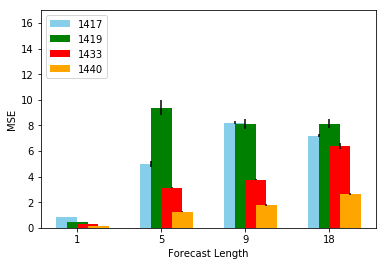

In [47]:
def loader():
    """Reading data from keys"""
    with open("results/rfr/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}    
    for key in keys:
        dictex[key] = pd.read_csv("results/rfr/results_{}.csv".format(str(key)))

    return dictex

results = loader()
graph_data = dict()
std_data = dict()
keys = [1417, 1419, 1433, 1440]

for key in keys:
    d = []
    st = []
    for i in [1, 5, 9, 18]:
        t = sum(results[(key, i)].values) / float(len(results[(key, i)]))
        s = np.std(results[(key, i)])[1]
        d.append(t[1])
        st.append(s)
    graph_data[key] = d
    std_data[key] = st

# Data for plotting
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ind = np.arange(len(graph_data[1417]))  # the x locations for the groups
width = 0.25  # the width of the bars

means, std = np.around(graph_data[1417], decimals=3), np.around(std_data[1417], decimals=3)
ax.bar(ind - width/2, means, width, yerr=std,
            color='SkyBlue', label=1417, align='center')

means, std = np.around(graph_data[1419], decimals=3), np.around(std_data[1419], decimals=3)
ax.bar(ind, means, width, yerr=std,
            color='Green', label=1419, align='center')

means, std = np.around(graph_data[1433], decimals=3), np.around(std_data[1433], decimals=3)
ax.bar(ind + width/2, means, width, yerr=std,
            color='Red', label=1433, align='center')

means, std = np.around(graph_data[1440], decimals=3), np.around(std_data[1440], decimals=3)
ax.bar(ind + width/2 + width/2, means, width, yerr=std,
            color='Orange', label=1440, align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MSE')
ax.set_xlabel('Forecast Length')
ax.set_xticks(ind)
ax.set_xticklabels((1, 5, 9, 18))
ax.legend(loc=2)
ax.set_ylim([0, 17])

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


#autolabel(rects1, "left")
#autolabel(rects2, "right")

plt.show()

In [48]:
print(rfr_params)

{(1419, 1): {'n_estimators': 136, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}, (1419, 5): {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}, (1419, 9): {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}, (1419, 18): {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}, (1433, 1): {'n_estimators': 52, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 60, 'bootstrap': True}, (1433, 5): {'n_estimators': 73, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}, (1433, 9): {'n_estimators': 157, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}, (1

In [17]:
def loader2():
    """Reading data from keys"""
    with open("data2/keys.txt", "r") as f:
        keys = eval(f.read())

    dictex = {}
    for key in keys:
        dictex[key] = pd.read_csv("data2/data_{}.csv".format(str(key)))

    return dictex

In [18]:
def experiment2(repeats, data, key, params):
    X_train, X_test, y_train, y_test = getValues(data)
    MSE_benchmark = 100
    index_val = 20

    error_scores = list()
    results = pd.DataFrame()
    
    predictionsBest = list()
    trueBest = list()
    print(key)
    for r in range(repeats):
        with open('models/rfr/model_{}_{}'.format(key, r), 'wb') as f:
            forest_model = pickle.load(f)

        predictions = forecast_forest(forest_model, X_test)
        true = y_test
    
        # report performance
        mse = mean_squared_error(true, predictions)
        print('%d) Test MSE: %.3f' % (r+1, mse))
        error_scores.append(mse)
        if (mse < MSE_benchmark):
            MSE_benchmark = mse
            predictionsBest = predictions
            trueBest = true
            index_val = r
        # plotPredictions(key, true, predictions)
    #for name, value in zip(INDEPENDENT_FEATURES, forest_model.feature_importances_):
        #print(value*100)
    #print(index_val, )
    return trueBest, predictionsBest, error_scores

In [19]:
%matplotlib inline

df = loader2()

import warnings
warnings.filterwarnings('ignore')

repeats = 10
features = 1
results = dict()
trueVals = []
predictedVals = []


def allowed_key(key):
    if  1 in key or 5 in key or 9 in key or 18 in key:
            return True
    return False

for key in df.keys():
    if allowed_key(key):
        true, predictions, error_scores = experiment(repeats, df[key], key, rfr_params[key])
        results[key] = error_scores
        trueVals.extend(true)
        predictedVals.extend(predictions)
    

(1419, 1)
1) Test MSE: 2.447
2) Test MSE: 2.531
3) Test MSE: 2.462
4) Test MSE: 2.495
5) Test MSE: 2.473
6) Test MSE: 2.451
7) Test MSE: 2.528
8) Test MSE: 2.506
9) Test MSE: 2.523
10) Test MSE: 2.471
(1419, 5)
1) Test MSE: 53.216
2) Test MSE: 63.985
3) Test MSE: 63.598
4) Test MSE: 62.278
5) Test MSE: 63.378
6) Test MSE: 64.575
7) Test MSE: 57.898
8) Test MSE: 59.768
9) Test MSE: 64.139
10) Test MSE: 65.279
(1419, 9)
1) Test MSE: 117.732
2) Test MSE: 111.900
3) Test MSE: 135.039
4) Test MSE: 113.451
5) Test MSE: 121.328
6) Test MSE: 130.642
7) Test MSE: 115.742
8) Test MSE: 132.122
9) Test MSE: 136.228
10) Test MSE: 111.987
(1419, 18)
1) Test MSE: 143.997
2) Test MSE: 141.649
3) Test MSE: 144.735
4) Test MSE: 157.110
5) Test MSE: 145.249
6) Test MSE: 137.014
7) Test MSE: 150.086
8) Test MSE: 149.310
9) Test MSE: 146.973
10) Test MSE: 162.042
(1433, 1)
1) Test MSE: 2.218
2) Test MSE: 2.216
3) Test MSE: 2.059
4) Test MSE: 2.101
5) Test MSE: 2.048
6) Test MSE: 2.303
7) Test MSE: 2.101
8)

In [20]:
import csv

def saver(dictex):
    for key, val in dictex.items():
        val = pd.DataFrame(val)
        val.to_csv("results2/rfr/results_{}.csv".format(str(key)))

    with open("results2/rfr/keys.txt", "w") as f: #saving keys to file
        f.write(str(list(dictex.keys())))
        
saver(results)